<a href="https://colab.research.google.com/github/siyeol/Few-Shot-Learning/blob/main/PrototypicalNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install easyfsl

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot,MNIST
from torchvision.models import resnet18
from tqdm import tqdm
import numpy as np
from easyfsl.data_tools import TaskSampler
from easyfsl.utils import plot_images, sliding_average

     |████████████████████████████████| 49 kB 2.0 MB/s 


# Define Model / Prototypical Networks

Reference: https://www.sicara.fr/blog/your-few-shot-model-15mn-pytorch


In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """

        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all support features vector with label i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()

model = PrototypicalNetworks(convolutional_network).cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# Now prepare the Data!
Num_channels is 3 because Resnet expects input of 3

In [ ]:
image_size = 28

train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([
                int(image_size * 1.15), int(image_size * 1.15)
            ]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


Now let's make the k-way, n-shot sets

In [ ]:
N_WAY = 5 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100
# get the labels
test_set.labels = [
    instance[1] for instance in test_set._flat_character_images
]

test_sampler = TaskSampler(
    test_set, 
    n_way=N_WAY, 
    n_shot=N_SHOT, 
    n_query=N_QUERY, 
    n_tasks=N_EVALUATION_TASKS,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Display some images just for kicks

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


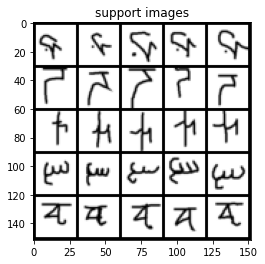

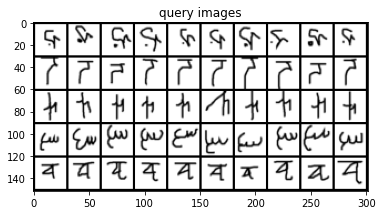

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

5-way,5-shot (describes support set). 10-way query set

# Training: 

## Let's see how the model does out of the box on this task
On the images above, it has an accuracy of 78%; not bad!

In [ ]:
model.eval() # set to evaluation mode
scores = model(example_support_images.cuda(),
               example_support_labels.cuda(),
               example_query_images.cuda()).detach()
# used Torch.max documentation for the next line
#https://pytorch.org/docs/stable/generated/torch.max.html
_,predicted_label = torch.max(scores,dim=1)

# Get things back on the cpu
# Used: https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html
predicted_label = predicted_label.detach().cpu().numpy()
# detach from NN graph, transfer to cpu, make to np.ndarray
true_label = example_query_labels.numpy()

# Compute the accuracy
correct,total = 0,0
for pred,real in zip(predicted_label,true_label):
  if pred == real:
    correct+=1
  total+=1
print("Accuracy is ",correct/total)

Accuracy is  0.7


##Let's get the average accuracy across all query/example sets:
The average Accuracy is 85%

In [ ]:
model.eval() # set to evaluation mode

data_iterator = iter(test_loader)
# an example refers to the tuple: (support_imgs,support_labels,query_images,query_labels,class_ids)
curExample = next(data_iterator,None)# return none if no other value left
AverageAccuracy = []
while curExample != None:
  (support_imgs,
  support_labels,
  query_images,
  query_labels,
  class_ids) = curExample
  scores = model(support_imgs.cuda(),
                  support_labels.cuda(),
                  query_images.cuda()).detach()
  _,predicted_label = torch.max(scores,dim=1)
  predicted_label = predicted_label.detach().cpu().numpy()
  true_label = query_labels.numpy()
  # Compute the accuracy
  correct,total = 0,0
  for pred,real in zip(predicted_label,true_label):
    if pred == real:
      correct+=1
    total+=1
  AverageAccuracy.append(correct/total)
  curExample = next(data_iterator,None)
# Now calculate Average Accuracy:
# print(AverageAccuracy)
AverageAccuracy = np.mean(AverageAccuracy)
print("The Average Accuracy is ",AverageAccuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The Average Accuracy is  0.8684000000000001


Up until now, our model is a ResNet trained on Cifar-10. So we need to train it on a different dataset, and see if it can still perform as well on Omniglot.

# Define Model trained on MNIST

### Define Model
Using an Untrained ResNet18


In [ ]:
model_MNIST = resnet18(pretrained=False)
# model_MNIST.fc = nn.Flatten()

### Prepare the MNIST DataSet

In [ ]:
image_size = 28

train_MNIST = MNIST(
    root="./data",
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_MNIST = MNIST(
    root="./data",
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([
                int(image_size), int(image_size)
            ]),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_MNIST_loader = DataLoader(train_MNIST,batch_size=64,shuffle=True)
test_MNIST_loader = DataLoader(test_MNIST,batch_size=64,shuffle=True)

### Train ResNet on MNIST

In [ ]:
EPOCHS = 20

# Optimizer and Loss Function
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_MNIST.parameters())

model_MNIST.train()
model_MNIST = model_MNIST.cuda()
for e in range(EPOCHS):
  running_loss = 0
  for i,data in enumerate(train_MNIST_loader):
    image,label = data
    image,label = image.cuda(),label.cuda()
    output = model_MNIST(image)
    loss = loss_fn(output,label)
    loss.backward()
    optim.step()
    running_loss+=loss.item()
    if i%500 == 499:
      print("Epoch ",e," Running Loss is ",running_loss/500)
      running_loss = 0

Epoch  0  Running Loss is  1.1890141237825156
Epoch  1  Running Loss is  0.3086102412622422
Epoch  2  Running Loss is  0.20558489719824866
Epoch  3  Running Loss is  0.3686814423138276
Epoch  4  Running Loss is  0.37670285945385695
Epoch  5  Running Loss is  0.24078099574707448
Epoch  6  Running Loss is  0.26001394902076574
Epoch  7  Running Loss is  0.26858696292340756
Epoch  8  Running Loss is  0.28228751674178054
Epoch  9  Running Loss is  0.2566614178996533
Epoch  10  Running Loss is  0.33367576224077494
Epoch  11  Running Loss is  0.24331109218299388
Epoch  12  Running Loss is  0.23276921017933636
Epoch  13  Running Loss is  0.21454157141083852
Epoch  14  Running Loss is  0.24070258899964392
Epoch  15  Running Loss is  0.2640553772095591
Epoch  16  Running Loss is  0.21493765912950039
Epoch  17  Running Loss is  0.2729250087533146
Epoch  18  Running Loss is  0.6583332367488183
Epoch  19  Running Loss is  0.22880760053545238


KeyboardInterrupt: ignored

#### Test on MNIST to see if we trained a good MNIST model

In [ ]:
model_MNIST.eval()
model_MNIST = model_MNIST.cuda()
count,total = 0,0
for i,data in enumerate(test_MNIST_loader):
  image,label = data
  image,label = image.cuda(),label.cuda()
  output = model_MNIST(image)
  _,pred = torch.max(output,1)
  for p,l in zip(pred,label):
    if p==l:
      count+=1
    total+=1
print("Accuracy on Test Set is ",100*count/total,"%")

52.15% when trained for 5 epochs


70.875% when trained for 10 epochs. I decided to move on bc I was excited to see how it would do on Omniglot


??% when trained for 20 epoches.

## Make Prototypical Net

In [ ]:
model_MNIST.fc = nn.Flatten()
proto_mnist = PrototypicalNetworks(model_MNIST).cuda()

## See what the average Accuracy is!

In [ ]:
proto_mnist.eval() # set to evaluation mode

data_iterator = iter(test_loader)
# an example refers to the tuple: (support_imgs,support_labels,query_images,query_labels,class_ids)
curExample = next(data_iterator,None)# return none if no other value left
AverageAccuracy = []
while curExample != None:
  (support_imgs,
  support_labels,
  query_images,
  query_labels,
  class_ids) = curExample
  scores = proto_mnist(support_imgs.cuda(),
                  support_labels.cuda(),
                  query_images.cuda()).detach()
  _,predicted_label = torch.max(scores,dim=1)
  predicted_label = predicted_label.detach().cpu().numpy()
  true_label = query_labels.numpy()
  # Compute the accuracy
  correct,total = 0,0
  for pred,real in zip(predicted_label,true_label):
    if pred == real:
      correct+=1
    total+=1
  AverageAccuracy.append(correct/total)
  curExample = next(data_iterator,None)
# Now calculate Average Accuracy:
# print(AverageAccuracy)
AverageAccuracy = np.mean(AverageAccuracy)
print("The Average Accuracy is ",AverageAccuracy)

34% when trained on MNIST, w MNIST Accuracy at 70%... hmmm

# Define Model trained on MNIST [Use Pretrained ResNet)

### Define Model
Using an PreTrained ResNet18


In [ ]:
model_MNIST = resnet18(pretrained=True)
model_MNIST.fc = nn.Linear(512,10) # added linear 10 April 23rd 5:58pm

### Prepare the MNIST DataSet

In [ ]:
image_size = 28

train_MNIST = MNIST(
    root="./data",
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
# we used to do random horizontal flips and resized crops
# this could make 9 look like 6's (horizontal flip) or 9 zoomed and cropped to the 
# loop and hence look like a zero
test_MNIST = MNIST(
    root="./data",
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([
                int(image_size), int(image_size)
            ]),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

In [ ]:
train_MNIST_loader = DataLoader(train_MNIST,batch_size=64,shuffle=True)
test_MNIST_loader = DataLoader(test_MNIST,batch_size=64,shuffle=True)

### Train ResNet on MNIST

In [ ]:
# model_MNIST = resnet18(pretrained=True)
# for param in model_MNIST.parameters():
#   param.requires_grad = False
# model_MNIST.fc = nn.Linear(512,10) # so now only fc will be updated... April 24th 1:48pm code
# from here: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
EPOCHS = 3

# Optimizer and Loss Function
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_MNIST.parameters())
# April 24th: tried only passing last layer's parameters

model_MNIST.train()
model_MNIST = model_MNIST.cuda()
for e in range(EPOCHS):
  running_loss = 0
  for i,data in enumerate(train_MNIST_loader):
    image,label = data
    image,label = image.cuda(),label.cuda()
    output = model_MNIST(image)
    loss = loss_fn(output,label)
    loss.backward()
    optim.step()
    running_loss+=loss.item()
    if i%500 == 499:
      print("Epoch ",e," Running Loss is ",running_loss/500)
      running_loss = 0

In [ ]:
torch.save(model_MNIST,'ResNet_pretrain_MNIST_10Epoches.pt')

#### Test on MNIST to see if we trained a good MNIST model

In [ ]:
model_MNIST.eval()
model_MNIST = model_MNIST.cuda()
count,total = 0,0
for i,data in enumerate(test_MNIST_loader):
  image,label = data
  image,label = image.cuda(),label.cuda()
  output = model_MNIST(image)
  _,pred = torch.max(output,1)
  for p,l in zip(pred,label):
    if p==l:
      count+=1
    total+=1
print("Accuracy on Test Set is ",100*count/total,"%")

23.87% when trained for 5 epochs Adam (default hyperparameters)

 5 epoches SGD lr=0.0001 momentum=0.9 loss was near 8 so I abandoned it

33% 10 epcochs Adam (default hyperparameters)

After fixing the horizontal flipping and cropping issue witht the data we now get:

95% on 3 epoches

## Make Prototypical Net

In [ ]:
model_MNIST.fc = nn.Flatten()
proto_mnist = PrototypicalNetworks(model_MNIST).cuda()

## See what the average Accuracy is!

In [ ]:
proto_mnist.eval() # set to evaluation mode

data_iterator = iter(test_loader)
# an example refers to the tuple: (support_imgs,support_labels,query_images,query_labels,class_ids)
curExample = next(data_iterator,None)# return none if no other value left
AverageAccuracy = []
while curExample != None:
  (support_imgs,
  support_labels,
  query_images,
  query_labels,
  class_ids) = curExample
  scores = proto_mnist(support_imgs.cuda(),
                  support_labels.cuda(),
                  query_images.cuda()).detach()
  _,predicted_label = torch.max(scores,dim=1)
  predicted_label = predicted_label.detach().cpu().numpy()
  true_label = query_labels.numpy()
  # Compute the accuracy
  correct,total = 0,0
  for pred,real in zip(predicted_label,true_label):
    if pred == real:
      correct+=1
    total+=1
  AverageAccuracy.append(correct/total)
  curExample = next(data_iterator,None)
# Now calculate Average Accuracy:
# print(AverageAccuracy)
AverageAccuracy = np.mean(AverageAccuracy)
print("The Average Accuracy is ",AverageAccuracy)

20% when trained on MNIST 10 epoches

After I fixed the image preprocessing

55% with 95% MNIST resnet

# Train with CIFAR-100

##import library

In [ ]:
import os
import torch
import torchvision
from torchvision.datasets import CIFAR100
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## CIFAR-100 

In [ ]:
transform1 = transforms.Compose([transforms.RandomResizedCrop(size=32, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=2), ToTensor()])

dataset = CIFAR100(root='data/', download=True, transform=ToTensor())
datasetplus = CIFAR100(root='data/', download=True, transform=transform1) 
# This "datasetplus" is to increase the dataset with more images

test_dataset = CIFAR100(root='data/', train=False, transform=ToTensor())

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 10000
train_size = 100000 - val_size

train_ds, val_ds = random_split((dataset+datasetplus), [train_size, val_size])
len(train_ds), len(val_ds)

In [ ]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

##MODEL

In [ ]:
class CIFAR100Model(ImageClassificationBase):
        def __init__(self):
                super().__init__()
                self.network = torchvision.models.resnet18(pretrained=True)
                num_ftrs = self.network.fc.in_features
                self.network.fc = nn.Linear(num_ftrs, 100)
        
        def forward(self, xb):
                return self.network(xb)
            
model = CIFAR100Model()

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, 
        weight_decay=0, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(CIFAR100Model(), device)
evaluate(model, val_dl)

##TRAIN

In [ ]:
opt_func = torch.optim.Adam
history = fit(10, 1e-5, model, train_dl, val_dl, 5e-4, opt_func)

In [ ]:
opt_func = torch.optim.Adam
history = fit(50, 1e-5, model, train_dl, val_dl, 5e-4, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 4.2729, val_loss: 3.9407, val_acc: 0.1144
Epoch [1], train_loss: 3.8045, val_loss: 3.6971, val_acc: 0.1500
Epoch [2], train_loss: 3.5916, val_loss: 3.5240, val_acc: 0.1778
Epoch [3], train_loss: 3.4357, val_loss: 3.4196, val_acc: 0.1936
Epoch [4], train_loss: 3.3159, val_loss: 3.3345, val_acc: 0.2141
Epoch [5], train_loss: 3.2060, val_loss: 3.2638, val_acc: 0.2275
Epoch [6], train_loss: 3.1147, val_loss: 3.2043, val_acc: 0.2336
Epoch [7], train_loss: 3.0371, val_loss: 3.1517, val_acc: 0.2461
Epoch [8], train_loss: 2.9621, val_loss: 3.1143, val_acc: 0.2514
Epoch [9], train_loss: 2.8881, val_loss: 3.0714, val_acc: 0.2609
Epoch [10], train_loss: 2.8243, val_loss: 3.0385, val_acc: 0.2685
Epoch [11], train_loss: 2.7638, val_loss: 3.0083, val_acc: 0.2721
Epoch [12], train_loss: 2.6998, val_loss: 2.9852, val_acc: 0.2815
Epoch [13], train_loss: 2.6396, val_loss: 2.9557, val_acc: 0.2849
Epoch [14], train_loss: 2.5858, val_loss: 2.9464, val_acc: 0.2870
Epoch [15], train_lo

##Change into PTN

In [ ]:
model.fc = nn.Flatten()
proto_mnist = PrototypicalNetworks(model).cuda()

##MNIST

In [ ]:
proto_mnist.eval() # set to evaluation mode

data_iterator = iter(test_loader)
# an example refers to the tuple: (support_imgs,support_labels,query_images,query_labels,class_ids)
curExample = next(data_iterator,None)# return none if no other value left
AverageAccuracy = []
while curExample != None:
  (support_imgs,
  support_labels,
  query_images,
  query_labels,
  class_ids) = curExample
  scores = proto_mnist(support_imgs.cuda(),
                  support_labels.cuda(),
                  query_images.cuda()).detach()
  _,predicted_label = torch.max(scores,dim=1)
  predicted_label = predicted_label.detach().cpu().numpy()
  true_label = query_labels.numpy()
  # Compute the accuracy
  correct,total = 0,0
  for pred,real in zip(predicted_label,true_label):
    if pred == real:
      correct+=1
    total+=1
  AverageAccuracy.append(correct/total)
  curExample = next(data_iterator,None)
# Now calculate Average Accuracy:
# print(AverageAccuracy)
AverageAccuracy = np.mean(AverageAccuracy)
print("The Average Accuracy is ",AverageAccuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The Average Accuracy is  0.7058


##OMNIGLOT

In [ ]:
N_WAY = 5 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100
# get the labels
test_set.labels = [
    instance[1] for instance in test_set._flat_character_images
]

test_sampler = TaskSampler(
    test_set, 
    n_way=N_WAY, 
    n_shot=N_SHOT, 
    n_query=N_QUERY, 
    n_tasks=N_EVALUATION_TASKS,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
proto_mnist.eval() # set to evaluation mode

data_iterator = iter(test_loader)
# an example refers to the tuple: (support_imgs,support_labels,query_images,query_labels,class_ids)
curExample = next(data_iterator,None)# return none if no other value left
AverageAccuracy = []
while curExample != None:
  (support_imgs,
  support_labels,
  query_images,
  query_labels,
  class_ids) = curExample
  scores = proto_mnist(support_imgs.cuda(),
                  support_labels.cuda(),
                  query_images.cuda()).detach()
  _,predicted_label = torch.max(scores,dim=1)
  predicted_label = predicted_label.detach().cpu().numpy()
  true_label = query_labels.numpy()
  # Compute the accuracy
  correct,total = 0,0
  for pred,real in zip(predicted_label,true_label):
    if pred == real:
      correct+=1
    total+=1
  AverageAccuracy.append(correct/total)
  curExample = next(data_iterator,None)
# Now calculate Average Accuracy:
# print(AverageAccuracy)
AverageAccuracy = np.mean(AverageAccuracy)
print("The Average Accuracy is ",AverageAccuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The Average Accuracy is  0.705
